## 读取文本，分词后存入列表words

In [1]:
def get_words(fname):
    words = []
    with open(fname) as fin:
      for line in fin:
        words += [w for w in line.strip().lower().split()]
    return words[:350000]

In [2]:
words = get_words('./data/sharedfiles/text8')
data_size = len(words)
print('Data size', data_size)

Data size 350000


## 构建词典

In [3]:
import nltk
import itertools
from collections import Counter, OrderedDict, deque

In [4]:
# 常见词词频下限
max_df=5
# 未登录词标记
unkown_token = '<UNK>'
# 填充上下文标记
pad_token = '<PAD>'
# 词语频次序列，未登录标记初始频次-1，填充标记初始频次0
word_freq = [[unkown_token, -1], [pad_token, 0]]
# 统计训练文本中各词频次，扩展到词语频次序列
word_freq.extend(nltk.FreqDist(itertools.chain(words)).most_common())
# 将词语频次序列转成字典<词语,频次>
word_freq = OrderedDict(word_freq)
# 词语2索引词典
word2idx = {unkown_token: 0, pad_token: 1}
# 索引2词语词典
idx2word = {0: unkown_token, 1: pad_token}
# 填充 词语2索引词典 和 索引2词语词典，罕见词标记为未登录词
idx = 2
for w in word_freq:
  f = word_freq[w]
  if f >= max_df:
    word2idx[w] = idx
    idx2word[idx] = w
    idx += 1
  else:
    word2idx[w] = 0 # map the rare word into the unkwon token
    word_freq[unkown_token] += 1 # increment the number of unknown tokens

## 索引文本

In [5]:
# 训练数据词语全部映射为索引
data = [word2idx[w] for w in words] 
# 节约内存，删掉words列表
del words
# 最常见的top5词语
most_common_words = list(word_freq.items())[:5]
print('Most common words (+UNK)', most_common_words)
# 训练数据前10个词语的索引和词语
print('Sample data', data[:10], [idx2word[i] for i in data[:10]])

Most common words (+UNK) [('<UNK>', 20177), ('<PAD>', 0), ('the', 22478), ('of', 12564), ('and', 9364)]
Sample data [340, 2628, 13, 7, 168, 3, 2797, 56, 67, 219] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [6]:
vocab_size = len(idx2word)
print("Vocabulary size", vocab_size)

Vocabulary size 6812


## 构建(上下文, 目标词)结构的训练数据

In [7]:
from six.moves import xrange  # pylint: disable=redefined-builtin
import numpy as np

In [8]:
def get_sample(data, data_size, word_idx, pad_token, c = 1):

  idx = max(0, word_idx - c)
  context = data[idx:word_idx]
  if word_idx + 1 < data_size:
    context += data[word_idx + 1 : min(data_size, word_idx + c + 1)]
  target = data[word_idx]
  context = [w for w in context if w != target]
  if len(context) > 0:
    return target, context + (2 * c - len(context)) * [pad_token]
  return None, None


def get_data_set(data, data_size, pad_token, c=1):
  contexts = []
  targets = []
  for i in xrange(data_size):
    target, context =  get_sample(data, data_size, i, pad_token, c)
    if not target is None:
      contexts.append(context)
      targets.append(target)

  return np.array(contexts, dtype='int32'), np.array(targets, dtype='int32')

In [9]:
# 构建窗口大小为2的上下文构成的训练数据
data_contexts, data_targets = get_data_set(data, data_size, word2idx[pad_token], c=2)

In [10]:
data_contexts.shape

(349569, 4)

In [11]:
data_targets.shape

(349569,)

In [12]:
data_size = data_contexts.shape[0]
print("训练实例数量=", data_size)
print([idx2word[i] for i in data_contexts[0]], idx2word[data_targets[0]])

训练实例数量= 349569
['originated', 'as', '<UNK>', '<UNK>'] anarchism


## 定义符号变量、共享变量、预测函数和损失函数

In [13]:
import theano
import theano.tensor as T
import math

In [14]:
# 将数据集作为共享变量，以便传输给GPU
data_contexts = theano.shared(data_contexts)
data_targets = theano.shared(data_targets)

In [15]:
def CBOW(vocab_size, emb_size):

    """
    CBOW: Function to define the CBOW model
    parameters:
        vocab_size: the vocabulary size
        emb_size: dimension of the embedding vector 隐藏层神经元数量
    return:
        List of theano variables [context, target], represents the model input,
        Theano function represents the loss (i.e. the cose or the objective) function,
        List of theano (shared) variable params, represents the parameters of the model.
    """
    # 上下文窗口变量
    context = T.imatrix(name='context')
    # 目标词变量
    target = T.ivector(name='target')
    # 输入层与隐藏层之间的初始权重矩阵
    W_in_values = np.asarray(np.random.uniform(-1.0, 1.0, (vocab_size, emb_size)),
                                dtype=theano.config.floatX)
    # 隐藏层与输出层之间的初始权重矩阵
    W_out_values = np.asarray(np.random.normal(scale=1.0 / math.sqrt(emb_size), size=(emb_size, vocab_size)),
                                dtype=theano.config.floatX)
    # 输入层与隐藏层之间的权重矩阵（共享变量，训练过程中更新）
    W_in = theano.shared(
            value=W_in_values,
            name='W_in',
            borrow=True)
    # 隐藏层与输出层之间的权重矩阵（共享变量，训练过程中更新）
    W_out = theano.shared(
            value=W_out_values,
            name='W_out',
            borrow=True)
    # 输入层到隐藏层的计算 input -> hidden (eq. 1)
    h = T.mean(W_in[context], axis=1)
    # 隐藏层到输出层的计算 hidden -> output (eq. 2)
    u = T.dot(h, W_out)
    # 多类别逻辑回归预测 softmax activation (eq. 3)
    p_target_given_contex = T.nnet.softmax(u) 
    # 损失函数 loss function (eq. 4)
    loss = -T.mean(T.log(p_target_given_contex)[T.arange(target.shape[0]), target])
    # 待训练的参数矩阵
    params = [W_in, W_out]

    return [context, target], loss, params, p_target_given_contex

In [16]:
# 隐藏层大小
emb_size = 128
# 创建上下文符号变量context，目标词符号变量target，损失函数loss，模型参数params
[context, target], loss, params, p_target_given_contex = CBOW(vocab_size, emb_size)

In [17]:
from theano import pp

In [18]:
pp(p_target_given_contex)

'Softmax(((Sum{axis=[1], acc_dtype=float64}(Reshape{3}(AdvancedSubtensor1(W_in, Reshape{1}(context, TensorConstant{(1,) of -1})), join(TensorConstant{0}, Shape(context), Shape(W_in)[int64:]))) / float64(Shape(Reshape{3}(AdvancedSubtensor1(W_in, Reshape{1}(context, TensorConstant{(1,) of -1})), join(TensorConstant{0}, Shape(context), Shape(W_in)[int64:]))))[Constant{1}]) \\dot W_out))'

In [19]:
from IPython.display import SVG

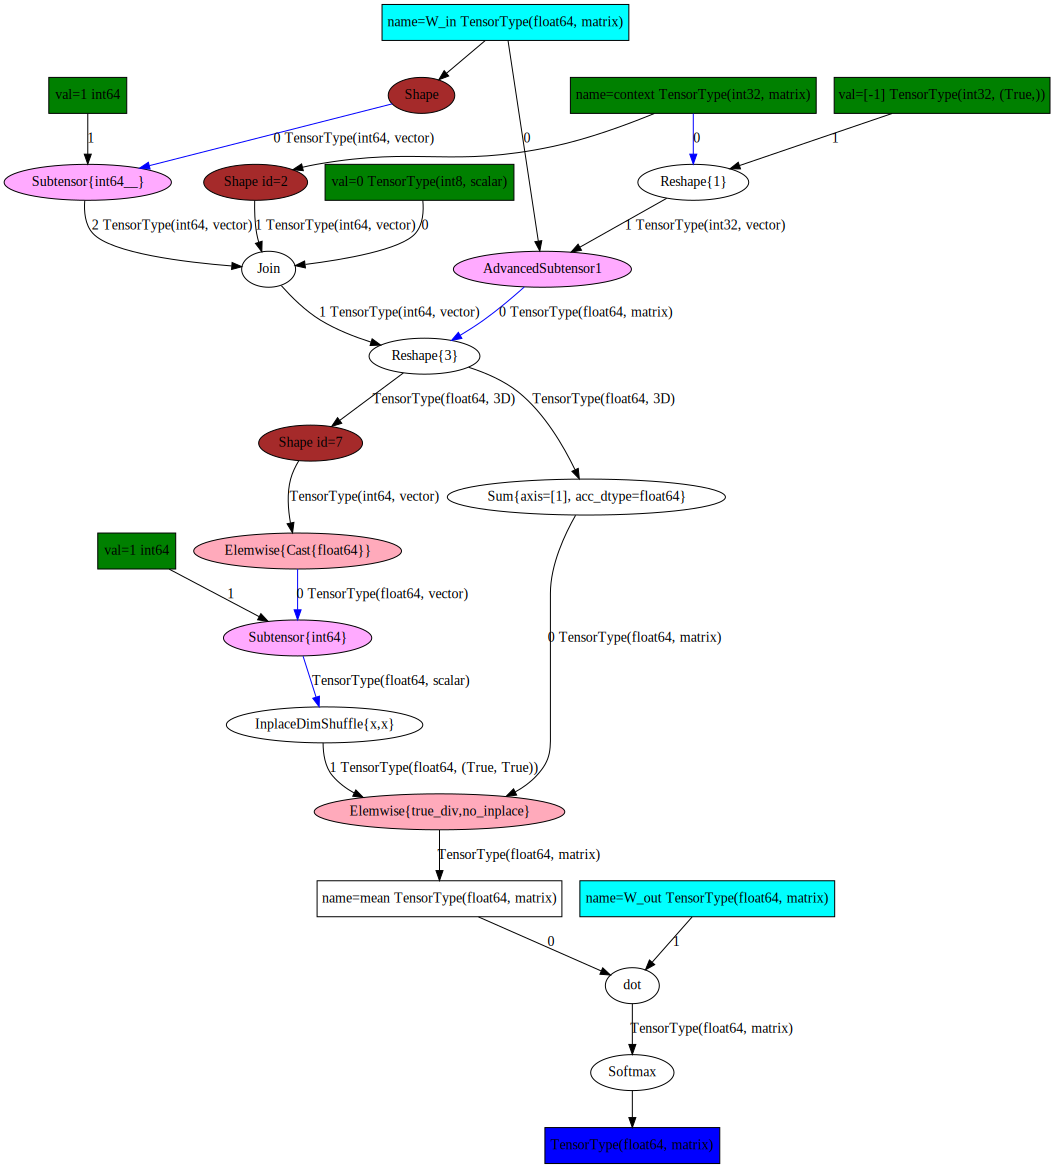

In [20]:
SVG(theano.printing.pydotprint(p_target_given_contex, return_image=True, format='svg'))

## 编译函数

In [21]:
def get_train_model(data, inputs, loss, params, batch_size=32):

    """
        trainer: Function to define the trainer of the model on the data set that bassed as the parameters of the function
        parameters:
            data: [(上下文数据1, 目标词1), (上下文数据2, 目标词2), ...., ]
            inputs: [上下文符号变量, 目标词符号变量]
            loss: 损失函数表达式
            params: 参数矩阵共享变量列表
        return:
            训练模型的函数
    """
    
    # 所有的上下文共享变量
    data_contexts = data[0]
    # 所有目标词共享变量
    data_targets = data[1]
    
    # 上下文符号变量
    context = inputs[0]
    # 目标词符号变量
    target = inputs[1]

    # 学习速率符号变量
    learning_rate = T.fscalar('learning_rate') # theano input: the learning rate, the value of this input
                                               # can be constant like 0.1 or
                                               # it can be come from a function like a decay learning rate function
    # mini批次的索引号
    index = T.lscalar('index') # the index of minibatch

    # 损失函数对模型参数的梯度
    g_params = T.grad(cost=loss, wrt=params)
    
    # 参数更新表达式
    updates = [
            (param, param - learning_rate * gparam)
            for param, gparam in zip(params, g_params)
    ]


    train_fun = theano.function(
        inputs = [index, learning_rate], # 输入变量
        outputs = loss, 
        updates = updates,               # 更新表达式
        givens={                         # 截取的批次数据
            context: data_contexts[index * batch_size: (index + 1) * batch_size],
            target: data_targets[index * batch_size: (index + 1) * batch_size]
        }
    )
    
    return train_fun

In [22]:
# 一个批次batch实例数量
batch_size = 32
# 编译训练模型
train_model = get_train_model([data_contexts, data_targets], [context, target], loss, params, batch_size)

## 开始训练

In [23]:
# 一个周期epoch所需的批次batch数量
n_train_batches = data_size // batch_size
# 训练周期epcho数量
n_epochs = 10
# 所需的总迭代iteration次数
n_iters = n_epochs * n_train_batches
# 记录每次迭代iteration后的系统损失值
train_loss = np.zeros(n_iters)
# 一定迭代iteration次数后的系统平均损失值
average_loss = 0

In [24]:
def save_params(outfile, params):
    """
    保存模型参数
    """
    l = []
    for param in params:
        l = l + [ param.get_value() ]
    np.savez(outfile+".npz", *l, flush=True)
    print("Saved model parameters to {}.npz".format(outfile))

In [25]:
# 学习速率
lr = 1.0
# 遍历周期

for epoch in range(n_epochs):
    # 遍历批次
    for minibatch_index in range(n_train_batches):
        # 计算迭代序号
        iteration = minibatch_index + n_train_batches * epoch
        # 训练模型
        curr_loss = train_model(minibatch_index, lr)
        # 记录当前损失
        train_loss[iteration] = curr_loss
        # 累加损失
        average_loss += curr_loss
        
        # 每2000次迭代
        if iteration % 2000 == 0:
            # 计算此时平均损失值
            if iteration > 0:
                average_loss /= 2000
            # 输出2000次 iteration的平均损失
            print("epoch ", epoch, "Average loss at iteration ", iteration, ": ", average_loss, flush=True)
            # 平均损失清0
            average_loss = 0
        
        # 每100000次迭代 保存模型参数
        if iteration % 100000 == 0:
            save_params("model_i{}".format(iteration), params)

epoch  0 Average loss at iteration  0 :  8.88876632456
Saved model parameters to model_i0.npz
epoch  0 Average loss at iteration  2000 :  6.66397613981
epoch  0 Average loss at iteration  4000 :  6.15077418158
epoch  0 Average loss at iteration  6000 :  6.04812540631
epoch  0 Average loss at iteration  8000 :  5.67822914481
epoch  0 Average loss at iteration  10000 :  5.8783891267
epoch  1 Average loss at iteration  12000 :  5.73932756927
epoch  1 Average loss at iteration  14000 :  5.49625930611
epoch  1 Average loss at iteration  16000 :  5.49060871426
epoch  1 Average loss at iteration  18000 :  5.30582008819
epoch  1 Average loss at iteration  20000 :  5.40950295226
epoch  2 Average loss at iteration  22000 :  5.39641699863
epoch  2 Average loss at iteration  24000 :  5.205812648
epoch  2 Average loss at iteration  26000 :  5.21323857003
epoch  2 Average loss at iteration  28000 :  5.16881682951
epoch  2 Average loss at iteration  30000 :  5.0537747414
epoch  2 Average loss at iter